<a href="https://colab.research.google.com/github/hnt4499/Aerial-Cactus-Identification/blob/master/Aerial_Cactus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from os import listdir
from PIL import Image

from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Activation, BatchNormalization,\
Add, Input, ZeroPadding2D, AveragePooling2D, GlobalMaxPooling2D, Dropout
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Transfrom all training and testing images into arrays and store it in csv files

In [0]:
from keras.preprocessing.image import load_img, img_to_array
from os import listdir
import pandas as pd
import numpy as np

In [0]:
imageList = listdir("/content/drive/My Drive/ML/Kaggle/5. Aerial Cactus Identification/test/")

In [0]:
cols = ["id"]
for i in range(3072):
  cols.append(i)

In [0]:
X_train = pd.DataFrame(columns=cols)

In [0]:
path = "/content/drive/My Drive/ML/Kaggle/5. Aerial Cactus Identification/test/"

In [0]:
count = 0
X_test = []
for i in imageList:
  image = load_img(path + i)
  image = img_to_array(image).reshape(1, 3072).tolist()[0]
  image.insert(0, i)
  X_test.append(image)
  if (count % 100 == 0):
    print("Processing image", count)
  count += 1
X_test = pd.DataFrame(X_test, columns=cols)
print("Done.")

Processing image 0
Processing image 100
Processing image 200
Processing image 300
Processing image 400
Processing image 500
Processing image 600
Processing image 700
Processing image 800
Processing image 900
Processing image 1000
Processing image 1100
Processing image 1200
Processing image 1300
Processing image 1400
Processing image 1500
Processing image 1600
Processing image 1700
Processing image 1800
Processing image 1900
Processing image 2000
Processing image 2100
Processing image 2200
Processing image 2300
Processing image 2400
Processing image 2500
Processing image 2600
Processing image 2700
Processing image 2800
Processing image 2900
Processing image 3000
Processing image 3100
Processing image 3200
Processing image 3300
Processing image 3400
Processing image 3500
Processing image 3600
Processing image 3700
Processing image 3800
Processing image 3900
Done.


In [0]:
X_train.head()

,id,0,1,2,3,4,5,6,7,8,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,7b984380d518c047fd1dfa29885ad889.jpg,122.0,112.0,120.0,107.0,97.0,105.0,108.0,98.0,106.0,...,130.0,143.0,117.0,130.0,124.0,100.0,113.0,170.0,146.0,159.0
1,7ba26dd96d2d6a3ed0f1d3eb062048d6.jpg,153.0,132.0,147.0,143.0,122.0,137.0,163.0,140.0,158.0,...,125.0,124.0,115.0,118.0,119.0,113.0,113.0,109.0,103.0,103.0
2,7bc54bf1a7e9988f2b7ad70eae9200a0.jpg,181.0,153.0,167.0,195.0,167.0,181.0,176.0,148.0,162.0,...,148.0,147.0,138.0,139.0,153.0,145.0,143.0,148.0,140.0,138.0
3,7bdb88b4e816d3094c8b3b5b2386e436.jpg,132.0,118.0,109.0,132.0,118.0,109.0,132.0,118.0,109.0,...,106.0,135.0,121.0,112.0,137.0,123.0,114.0,123.0,109.0,100.0
4,7bed9596047ca6452e723a22dc1215a6.jpg,157.0,140.0,146.0,155.0,138.0,144.0,155.0,138.0,144.0,...,126.0,164.0,145.0,147.0,142.0,123.0,125.0,131.0,113.0,113.0


In [0]:
X_test.sort_values("id", ascending=True).to_csv("/content/drive/My Drive/ML/Kaggle/5. Aerial Cactus Identification/test_images.csv", index=False)

# Read input

In [0]:
train_images = pd.read_csv("/content/drive/My Drive/ML/Kaggle/5. Aerial Cactus Identification/train_images.csv")

In [0]:
train_images.tail()

# We can see that the order of images is identical to the order of images in train.csv (which is also labels)

,id,0,1,2,3,4,5,6,7,8,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
17495,ffede47a74e47a5930f81c0b6896479e.jpg,154.0,144.0,143.0,154.0,144.0,143.0,154.0,144.0,143.0,...,145.0,154.0,144.0,143.0,158.0,148.0,147.0,164.0,154.0,153.0
17496,ffef6382a50d23251d4bc05519c91037.jpg,236.0,220.0,233.0,231.0,215.0,228.0,255.0,242.0,255.0,...,143.0,123.0,109.0,126.0,160.0,146.0,163.0,132.0,118.0,135.0
17497,fff059ecc91b30be5745e8b81111dc7b.jpg,100.0,91.0,96.0,132.0,123.0,128.0,221.0,212.0,217.0,...,97.0,124.0,114.0,115.0,124.0,115.0,116.0,113.0,104.0,105.0
17498,fff43acb3b7a23edcc4ae937be2b7522.jpg,146.0,131.0,134.0,161.0,146.0,149.0,153.0,138.0,141.0,...,128.0,143.0,128.0,131.0,160.0,145.0,148.0,145.0,130.0,133.0
17499,fffd9e9b990eba07c836745d8aef1a3a.jpg,176.0,148.0,163.0,149.0,121.0,136.0,154.0,126.0,141.0,...,125.0,129.0,134.0,128.0,107.0,112.0,106.0,93.0,98.0,92.0


In [0]:
X_train = train_images.iloc[:, 1:].values.reshape(-1, 32, 32, 3)

In [0]:
Y_train = pd.read_csv("/content/drive/My Drive/ML/Kaggle/5. Aerial Cactus Identification/train.csv")

In [0]:
Y_train.tail(5)

,id,has_cactus
17495,ffede47a74e47a5930f81c0b6896479e.jpg,0
17496,ffef6382a50d23251d4bc05519c91037.jpg,1
17497,fff059ecc91b30be5745e8b81111dc7b.jpg,1
17498,fff43acb3b7a23edcc4ae937be2b7522.jpg,0
17499,fffd9e9b990eba07c836745d8aef1a3a.jpg,1


In [0]:
Y_train = Y_train.sort_values("id", ascending=True).has_cactus

In [0]:
test_images = pd.read_csv("/content/drive/My Drive/ML/Kaggle/5. Aerial Cactus Identification/test_images.csv")

In [0]:
test_images.head()

,id,0,1,2,3,4,5,6,7,8,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,000940378805c44108d287872b2f04ce.jpg,57.0,59.0,54.0,54.0,56.0,51.0,27.0,29.0,24.0,...,102.0,114.0,101.0,111.0,129.0,116.0,126.0,109.0,96.0,106.0
1,0017242f54ececa4512b4d7937d1e21e.jpg,80.0,71.0,72.0,85.0,76.0,77.0,84.0,76.0,74.0,...,66.0,117.0,101.0,111.0,59.0,43.0,53.0,65.0,49.0,59.0
2,001ee6d8564003107853118ab87df407.jpg,97.0,92.0,73.0,120.0,117.0,98.0,141.0,138.0,119.0,...,113.0,106.0,131.0,99.0,91.0,116.0,84.0,84.0,109.0,77.0
3,002e175c3c1e060769475f52182583d0.jpg,112.0,98.0,98.0,110.0,96.0,96.0,117.0,103.0,103.0,...,118.0,150.0,138.0,140.0,162.0,150.0,152.0,161.0,149.0,151.0
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,87.0,80.0,87.0,90.0,80.0,88.0,97.0,87.0,95.0,...,56.0,55.0,43.0,45.0,52.0,40.0,42.0,56.0,44.0,46.0


In [0]:
X_test = test_images.iloc[:, 1:].values.reshape(-1, 32, 32, 3)

In [0]:
submission = pd.DataFrame(test_images.iloc[:, 0], columns=["id"])

***Split Training set and Validation set***

In [0]:
#X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=4)

***See how the classes are distributed***

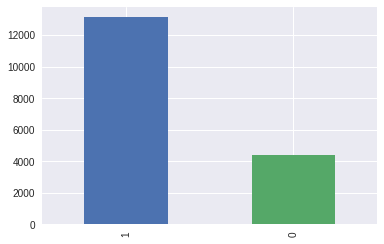

In [0]:
Y_train.value_counts().plot.bar()

# Basic Parameters

In [0]:
epochs = 10
batch_size = 64

***See how our I/O works***

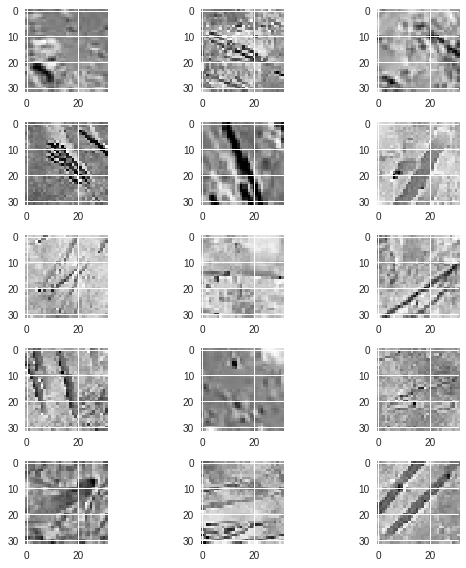

In [0]:
plt.figure(figsize=(8, 8))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    j = np.random.randint(0, Y_train.shape[0])
    plt.imshow(X_train[j][:, :, 0])
plt.tight_layout()
plt.show()

# Use several pre-trained models to train and pick the best model

In [0]:
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
#from keras.applications.resnet_v2 import ResNet152V2
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.densenet import DenseNet201
from keras.applications.nasnet import NASNetLarge

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, \
                                            factor=0.7, min_lr=0.00001)

In [0]:
datagen = ImageDataGenerator(rotation_range=30, width_shift_range=0.2, 
                             height_shift_range=0.2, zoom_range=0.2, 
                             horizontal_flip=True, vertical_flip=True, 
                             validation_split=0.1)

In [0]:
train_generator = datagen.flow(X_train, Y_train, batch_size=batch_size, subset='training')
val_generator = datagen.flow(X_train, Y_train, batch_size=batch_size, subset='validation')

In [0]:
def buildModel(base_model):
  X = base_model.output
  X = Flatten()(X)
  X = Dense(512, activation='relu', kernel_regularizer='l2')(X)
  X = Dense(1, activation='sigmoid')(X)
  
  model = Model(inputs=base_model.input, outputs=X)
  
  return model

In [0]:
def fitModel(model, cpoint=False):

  # Freeze 80% layers
  threshold = int(len(model.layers) * 0.8)
  for i in model.layers[:threshold]:
    i.trainable = False
  for i in model.layers[threshold:]:
    i.trainable = True

  # Compile model
  model.compile(optimizer=Adam(lr=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

  # Train model
  cb = [learning_rate_reduction, checkpoint] if cpoint else [learning_rate_reduction]
  history.append(model.fit_generator(generator=train_generator, epochs=epochs,
                                     steps_per_epoch=int(X_train.shape[0] // batch_size * 1.5),
                                     validation_data=val_generator, 
                                     validation_steps=int(X_train.shape[0] // batch_size * 0.4),
                                     callbacks=cb))
  return model

In [0]:
history = []

***Xception***

In [0]:
checkpoint = ModelCheckpoint("/content/drive/My Drive/ML/Kaggle/5. Aerial Cactus Identification/xception_80.h5", \
                             monitor="val_acc", verbose=1, save_best_only=True, mode='max')

In [0]:
# Build model
X_input = Input((32, 32, 3))
base_model = Xception(weights="imagenet", include_top=False, input_tensor=X_input)
model = buildModel(base_model)

# Train model
fitModel(model)

Epoch 1/10
409/409 [==============================] - 43s 104ms/step - loss: 0.7935 - acc: 0.9119 - val_loss: 4.1814 - val_acc: 0.7388

Epoch 00001: val_acc did not improve from 0.75043
Epoch 2/10
409/409 [==============================] - 33s 80ms/step - loss: 0.1132 - acc: 0.9648 - val_loss: 11.2286 - val_acc: 0.2888

Epoch 00002: val_acc did not improve from 0.75043
Epoch 3/10
409/409 [==============================] - 33s 81ms/step - loss: 0.1006 - acc: 0.9691 - val_loss: 11.0059 - val_acc: 0.2980

Epoch 00003: val_acc did not improve from 0.75043
Epoch 4/10
409/409 [==============================] - 32s 79ms/step - loss: 0.0972 - acc: 0.9696 - val_loss: 9.3823 - val_acc: 0.3803

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00035000001662410796.

Epoch 00004: val_acc did not improve from 0.75043
Epoch 5/10
409/409 [==============================] - 33s 80ms/step - loss: 0.0788 - acc: 0.9751 - val_loss: 7.9298 - val_acc: 0.4559

Epoch 00005: val_acc did not improve fro

***VGG16***

In [0]:
# Build model
X_input = Input((32, 32, 3))
base_model = VGG16(weights="imagenet", include_top=False, input_tensor=X_input)
model = buildModel(base_model)

# Train model
fitModel(model)

58892288/58889256 [==============================] - 1s 0us/step
Epoch 1/10
409/409 [==============================] - 36s 89ms/step - loss: 3.2879 - acc: 0.9162 - val_loss: 3.5537 - val_acc: 0.8461

Epoch 00001: val_acc improved from -inf to 0.84613, saving model to /content/drive/My Drive/ML/Kaggle/5. Aerial Cactus Identification/vgg16_80.h5
Epoch 2/10
409/409 [==============================] - 28s 68ms/step - loss: 2.0731 - acc: 0.9225 - val_loss: 1.5164 - val_acc: 0.9445

Epoch 00002: val_acc improved from 0.84613 to 0.94448, saving model to /content/drive/My Drive/ML/Kaggle/5. Aerial Cactus Identification/vgg16_80.h5
Epoch 3/10
409/409 [==============================] - 29s 71ms/step - loss: 1.4330 - acc: 0.9421 - val_loss: 1.1170 - val_acc: 0.9555

Epoch 00003: val_acc improved from 0.94448 to 0.95549, saving model to /content/drive/My Drive/ML/Kaggle/5. Aerial Cactus Identification/vgg16_80.h5
Epoch 4/10
409/409 [==============================] - 28s 69ms/step - loss: 1.3475 - a

***VGG19***

In [0]:
# Build model
X_input = Input((32, 32, 3))
base_model = VGG19(weights="imagenet", include_top=False, input_tensor=X_input)
model = buildModel(base_model)

# Train model
fitModel(model)

80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/10
409/409 [==============================] - 37s 91ms/step - loss: 3.6003 - acc: 0.8937 - val_loss: 2.2935 - val_acc: 0.9235
Epoch 2/10
409/409 [==============================] - 28s 69ms/step - loss: 2.0278 - acc: 0.9242 - val_loss: 1.7065 - val_acc: 0.9311
Epoch 3/10
409/409 [==============================] - 29s 71ms/step - loss: 1.7369 - acc: 0.9218 - val_loss: 1.4728 - val_acc: 0.9321
Epoch 4/10
409/409 [==============================] - 29s 71ms/step - loss: 1.6269 - acc: 0.9183 - val_loss: 1.3357 - val_acc: 0.9333
Epoch 5/10
409/409 [==============================] - 29s 71ms/step - loss: 1.2615 - acc: 0.9347 - val_loss: 1.6676 - val_acc: 0.9056
Epoch 6/10
409/409 [==============================] - 29s 70ms/step - loss: 1.3474 - acc: 0.9250 - val_loss: 1.1717 - val_acc: 0.9349
Epoch 7/10
409/409 [==============================] - 29s 71ms/step - loss: 1.2413 - acc: 0.9294 - val_loss: 1.1297 - val_acc: 0.93

***ResNeXt101***

In [0]:
# Build model
X_input = Input((32, 32, 3))
base_model = ResNeXt101(weights="imagenet", include_top=False, input_tensor=X_input)
model = buildModel(base_model)

# Train model
fitModel(model)

***InceptionV3***

In [0]:
# Build model
X_input = Input((32, 32, 3))
base_model = InceptionV3(weights="imagenet", include_top=False, input_tensor=X_input)
model = buildModel(base_model)

# Freeze 80% layers
threshold = int(len(model.layers) * 0.8)
for i in model.layers[:threshold]:
  i.trainable = False
for i in model.layers[threshold:]:
  i.trainable = True
  
# Compile model
model.compile(optimizer=Adam(lr=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history.append(model.fit_generator(generator=train_generator, epochs=epochs,
                                   steps_per_epoch=int(X_train.shape[0] // batch_size * 1.5),
                                   validation_data=val_generator, 
                                   validation_steps=int(X_train.shape[0] // batch_size * 0.4),
                                   callbacks=[learning_rate_reduction]))

***InceptionResNetV2***

In [0]:
# Build model
X_input = Input((32, 32, 3))
base_model = InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=X_input)
model = buildModel(base_model)

# Train model
fitModel(model)

***MobileNetV2***

In [0]:
# Build model
X_input = Input((32, 32, 3))
base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=X_input)
model = buildModel(base_model)

# Train model
fitModel(model)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:295: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


9412608/9406464 [==============================] - 0s 0us/step
Epoch 1/10
409/409 [==============================] - 46s 112ms/step - loss: 1.6347 - acc: 0.9071 - val_loss: 0.8308 - val_acc: 0.6817
Epoch 2/10
409/409 [==============================] - 30s 74ms/step - loss: 0.2026 - acc: 0.9285 - val_loss: 1.2681 - val_acc: 0.7251
Epoch 3/10
409/409 [==============================] - 31s 75ms/step - loss: 0.1801 - acc: 0.9320 - val_loss: 0.9968 - val_acc: 0.5922
Epoch 4/10
409/409 [==============================] - 31s 76ms/step - loss: 0.1894 - acc: 0.9355 - val_loss: 0.7479 - val_acc: 0.5236
Epoch 5/10
409/409 [==============================] - 31s 75ms/step - loss: 0.1722 - acc: 0.9356 - val_loss: 1.2891 - val_acc: 0.3321

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00035000001662410796.
Epoch 6/10
409/409 [==============================] - 31s 75ms/step - loss: 0.1528 - acc: 0.9422 - val_loss: 0.7006 - val_acc: 0.6945
Epoch 7/10
409/409 [==============================

***DenseNet201***

In [0]:
# Build model
X_input = Input((32, 32, 3))
base_model = DenseNet201(weights="imagenet", include_top=False, input_tensor=X_input)
model = buildModel(base_model)

# Train model
fitModel(model)

74842112/74836368 [==============================] - 1s 0us/step
Epoch 1/10
409/409 [==============================] - 108s 263ms/step - loss: 1.0955 - acc: 0.9511 - val_loss: 4.0938 - val_acc: 0.7403
Epoch 2/10
409/409 [==============================] - 69s 168ms/step - loss: 0.1012 - acc: 0.9690 - val_loss: 3.5426 - val_acc: 0.7460
Epoch 3/10
409/409 [==============================] - 69s 168ms/step - loss: 0.0817 - acc: 0.9740 - val_loss: 3.7949 - val_acc: 0.7431
Epoch 4/10
409/409 [==============================] - 69s 169ms/step - loss: 0.0806 - acc: 0.9736 - val_loss: 2.1778 - val_acc: 0.7969
Epoch 5/10
409/409 [==============================] - 69s 169ms/step - loss: 0.0720 - acc: 0.9765 - val_loss: 3.4626 - val_acc: 0.7543
Epoch 6/10
409/409 [==============================] - 69s 168ms/step - loss: 0.0728 - acc: 0.9760 - val_loss: 4.1578 - val_acc: 0.7396
Epoch 7/10
409/409 [==============================] - 69s 168ms/step - loss: 0.0691 - acc: 0.9782 - val_loss: 0.9491 - val_a

***NASNetLarge***

In [0]:
# Build model
X_input = Input((32, 32, 3))
base_model = NASNetLarge(weights="imagenet", include_top=False, input_tensor=X_input)
model = buildModel(base_model)

# Train model
fitModel(model)

343613440/343610240 [==============================] - 3s 0us/step
Epoch 1/10
409/409 [==============================] - 189s 462ms/step - loss: 1.1958 - acc: 0.9104 - val_loss: 11.9443 - val_acc: 0.2612
Epoch 2/10
409/409 [==============================] - 126s 308ms/step - loss: 0.2079 - acc: 0.9329 - val_loss: 4.2015 - val_acc: 0.7381
Epoch 3/10
409/409 [==============================] - 126s 309ms/step - loss: 0.1721 - acc: 0.9409 - val_loss: 11.9527 - val_acc: 0.2591
Epoch 4/10
409/409 [==============================] - 126s 309ms/step - loss: 0.1635 - acc: 0.9432 - val_loss: 11.9092 - val_acc: 0.2619
Epoch 5/10
409/409 [==============================] - 126s 309ms/step - loss: 0.1578 - acc: 0.9455 - val_loss: 11.9576 - val_acc: 0.2588

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00035000001662410796.
Epoch 6/10
409/409 [==============================] - 126s 309ms/step - loss: 0.1424 - acc: 0.9487 - val_loss: 11.8962 - val_acc: 0.2625
Epoch 7/10
409/409 [==========

***Plot only validation set info***

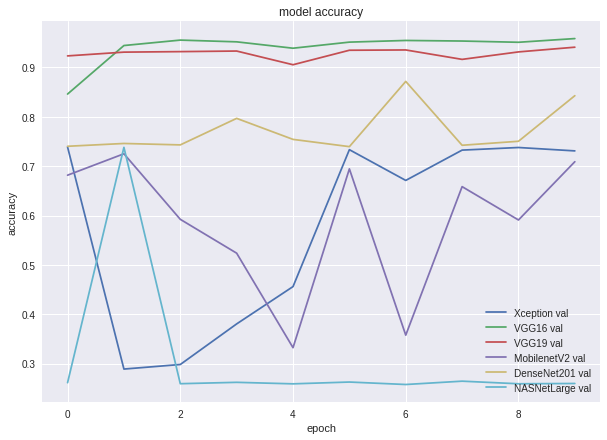

In [0]:
plt.figure(figsize=(10, 7))
for i, j in enumerate(history):
  plt.plot(j.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(["Xception val", "VGG16 val", 
            "VGG19 val", "MobilenetV2 val",
            "DenseNet201 val", "NASNetLarge val"], 
           loc='lower right')
plt.show()

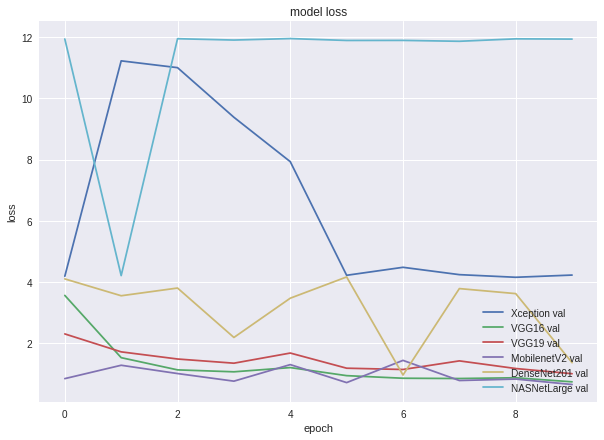

In [0]:
plt.figure(figsize=(10, 7))
for i, j in enumerate(history):
  plt.plot(j.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["Xception val", "VGG16 val", 
            "VGG19 val", "MobilenetV2 val",
            "DenseNet201 val", "NASNetLarge val"], 
           loc='lower right')
plt.show()

***As we can see from the benchmark, VGG16 and VGG19 give us the best model. Now we will continue training these models on a larger number of epochs***

In [0]:
epochs = 200
history = []

# VGG16

***Training model***

In [0]:
checkpoint = ModelCheckpoint("/content/drive/My Drive/ML/Kaggle/5. Aerial Cactus Identification/vgg16.h5", \
                             monitor="val_acc", verbose=1, save_best_only=True, mode='max')

In [0]:
# Build model
X_input = Input((32, 32, 3))
base_model = VGG16(weights="imagenet", include_top=False, input_tensor=X_input)
model = buildModel(base_model)

# Train model
model = fitModel(model, cpoint=True)

Epoch 1/200
409/409 [==============================] - 29s 72ms/step - loss: 3.4418 - acc: 0.9002 - val_loss: 2.7497 - val_acc: 0.8920

Epoch 00001: val_acc improved from -inf to 0.89204, saving model to /content/drive/My Drive/ML/Kaggle/5. Aerial Cactus Identification/vgg16.h5
Epoch 2/200
409/409 [==============================] - 28s 69ms/step - loss: 1.8316 - acc: 0.9338 - val_loss: 1.5486 - val_acc: 0.9401

Epoch 00002: val_acc improved from 0.89204 to 0.94007, saving model to /content/drive/My Drive/ML/Kaggle/5. Aerial Cactus Identification/vgg16.h5
Epoch 3/200
409/409 [==============================] - 29s 70ms/step - loss: 1.4650 - acc: 0.9382 - val_loss: 1.1532 - val_acc: 0.9517

Epoch 00003: val_acc improved from 0.94007 to 0.95167, saving model to /content/drive/My Drive/ML/Kaggle/5. Aerial Cactus Identification/vgg16.h5
Epoch 4/200
409/409 [==============================] - 29s 71ms/step - loss: 1.3852 - acc: 0.9328 - val_loss: 1.3599 - val_acc: 0.9305

Epoch 00004: val_acc 

KeyboardInterrupt: ignored

***Making predictions and submission***

In [0]:
model = load_model("/content/drive/My Drive/ML/Kaggle/5. Aerial Cactus Identification/vgg16.h5")

In [0]:
pred = model.predict(X_test).reshape(-1)

In [0]:
submission["has_cactus"] = pd.Series(pred, index=None)

In [0]:
submission.to_csv("/content/drive/My Drive/ML/Kaggle/5. Aerial Cactus Identification/vgg16_submission.csv", index=False)